## 📝 Project Summary

This notebook implements and compares two models for patch-based image similarity: **MatchNet** and a **BEIT**. Both models are trained and evaluated on the Tiny ImageNet dataset using PyTorch. Training was conducted on Google Colab GPUs for efficient computation.


**MATCHNET MODEL**

In [ ]:
# === Setup ===
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
import random

In [ ]:
# === Load Dataset ===
train_dataset = load_dataset('slegroux/tiny-imagenet-200-clean', split='train')
val_dataset = load_dataset('slegroux/tiny-imagenet-200-clean', split='validation')
test_dataset = load_dataset('slegroux/tiny-imagenet-200-clean', split='test')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.54k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/151M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/7.54M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/7.57M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/98179 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/4909 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/4923 [00:00<?, ? examples/s]

In [ ]:
# === Transformations ===
transform = T.Compose([
    T.Resize((64, 64)),
    T.ToTensor(),
    T.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

In [ ]:
# === ImagePairs Dataset ===
class ImagePairsDataset(Dataset):
    def __init__(self, hf_dataset, transform, mode='train'):
        self.dataset = hf_dataset
        self.transform = transform
        self.mode = mode
        self.label_to_indices = {}
        for i, ex in enumerate(hf_dataset):
            label = ex['label']
            self.label_to_indices.setdefault(label, []).append(i)
        self.indices = list(range(len(hf_dataset)))

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        anchor = self.dataset[idx]
        anchor_img = self.transform(anchor['image'])
        anchor_label = anchor['label']

        if self.mode == 'test':
            pair_idx = (idx + 1) % len(self.dataset)
            pair = self.dataset[pair_idx]
            pair_img = self.transform(pair['image'])
            label = 1 if pair['label'] == anchor_label else 0
        else:
            if random.random() < 0.5:
                label = 1
                pos_idx = random.choice(self.label_to_indices[anchor_label])
                while pos_idx == idx:
                    pos_idx = random.choice(self.label_to_indices[anchor_label])
                pair_img = self.transform(self.dataset[pos_idx]['image'])
            else:
                label = 0
                neg_label = random.choice([l for l in self.label_to_indices if l != anchor_label])
                neg_idx = random.choice(self.label_to_indices[neg_label])
                pair_img = self.transform(self.dataset[neg_idx]['image'])

        return anchor_img, pair_img, torch.tensor([label], dtype=torch.float32)

In [ ]:
# === MatchNet Model ===
class MatchNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 24, kernel_size=7, stride=1, padding=3),  # Conv0
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),  # Pool0

            nn.Conv2d(24, 64, kernel_size=5, padding=2),  # Conv1
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),  # Pool1

            nn.Conv2d(64, 96, kernel_size=3, padding=1),  # Conv2
            nn.ReLU(),
            nn.Conv2d(96, 96, kernel_size=3, padding=1),  # Conv3
            nn.ReLU(),
            nn.Conv2d(96, 64, kernel_size=3, padding=1),  # Conv4
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)  # Pool4
        )
        self.bottleneck = nn.Linear(8 * 8 * 64, 128)
        self.metric_network = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def extract_features(self, x):
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)
        return self.bottleneck(x)

    def forward(self, x1, x2):
        f1 = self.extract_features(x1)
        f2 = self.extract_features(x2)
        pair = torch.cat([f1, f2], dim=1)
        return self.metric_network(pair)


In [ ]:
# === Loaders ===
train_loader = DataLoader(ImagePairsDataset(train_dataset, transform, 'train'), batch_size=32, shuffle=True)
val_loader = DataLoader(ImagePairsDataset(val_dataset, transform, 'val'), batch_size=32)
test_loader = DataLoader(ImagePairsDataset(test_dataset, transform, 'test'), batch_size=32)

In [ ]:
# === Train and Validate ===
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss, correct = 0, 0
    for img1, img2, labels in dataloader:
        img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(img1, img2).squeeze()
        loss = criterion(outputs, labels.squeeze())
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * img1.size(0)
        correct += (outputs > 0.5).eq(labels.squeeze()).sum().item()
    return total_loss / len(dataloader.dataset), correct / len(dataloader.dataset)

def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for img1, img2, labels in dataloader:
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
            outputs = model(img1, img2).squeeze()
            loss = criterion(outputs, labels.squeeze())
            total_loss += loss.item() * img1.size(0)
            correct += (outputs > 0.5).eq(labels.squeeze()).sum().item()
    return total_loss / len(dataloader.dataset), correct / len(dataloader.dataset)


🔁 Training with learning rate: 0.0001
Epoch 1: Train Loss 0.6932, Acc 0.4970 | Val Loss 0.6931, Acc 0.5066
Epoch 2: Train Loss 0.6854, Acc 0.5370 | Val Loss 0.6769, Acc 0.5671
Epoch 3: Train Loss 0.6738, Acc 0.5702 | Val Loss 0.6702, Acc 0.5816
Epoch 4: Train Loss 0.6694, Acc 0.5798 | Val Loss 0.6660, Acc 0.5824
Epoch 5: Train Loss 0.6572, Acc 0.5988 | Val Loss 0.6552, Acc 0.5977


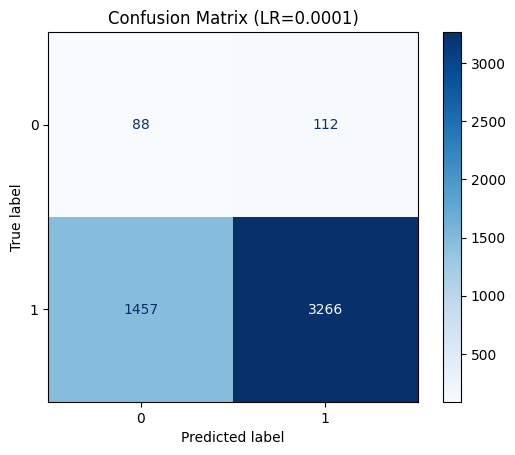

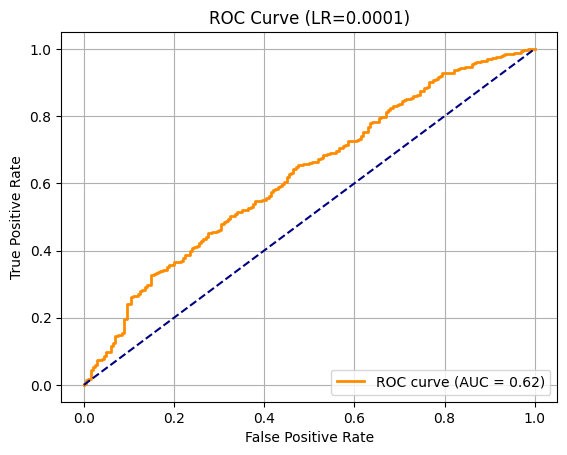

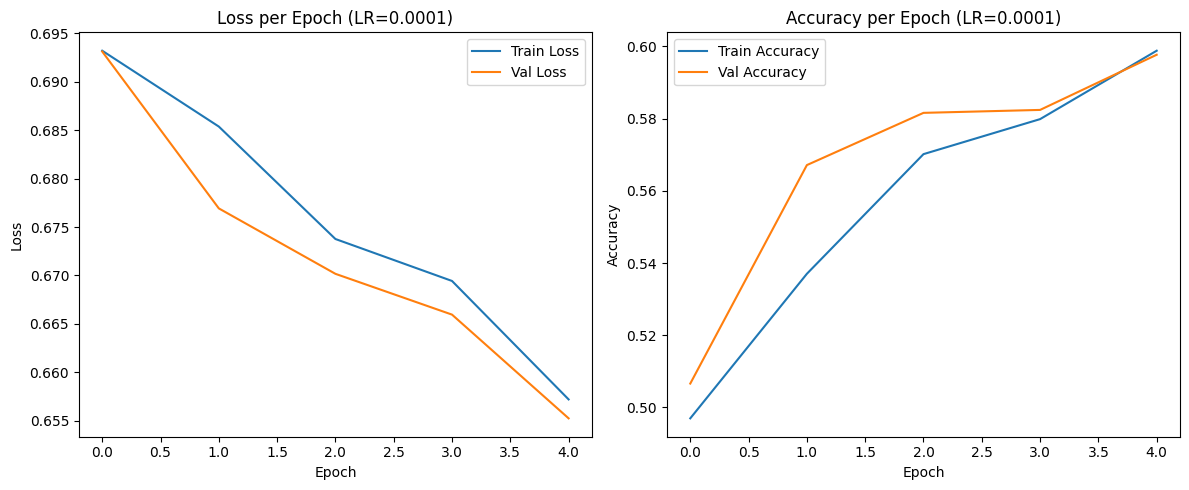

✅ Saved model to matchnet_lr_1e-04.pth

🔁 Training with learning rate: 0.0005
Epoch 1: Train Loss 0.6932, Acc 0.5012 | Val Loss 0.6929, Acc 0.5129
Epoch 2: Train Loss 0.6932, Acc 0.4988 | Val Loss 0.6930, Acc 0.5093
Epoch 3: Train Loss 0.6932, Acc 0.5016 | Val Loss 0.6932, Acc 0.4958
Epoch 4: Train Loss 0.6932, Acc 0.4986 | Val Loss 0.6933, Acc 0.4954
Epoch 5: Train Loss 0.6932, Acc 0.5014 | Val Loss 0.6931, Acc 0.5188


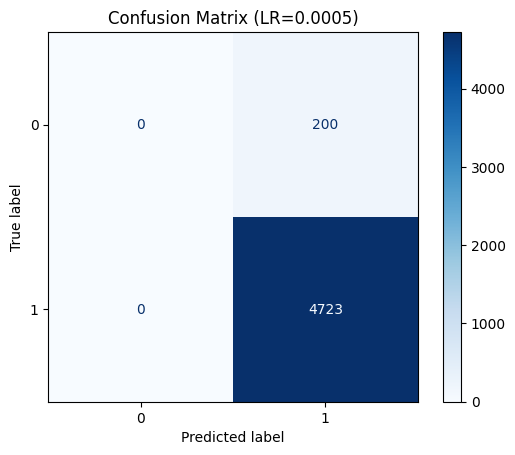

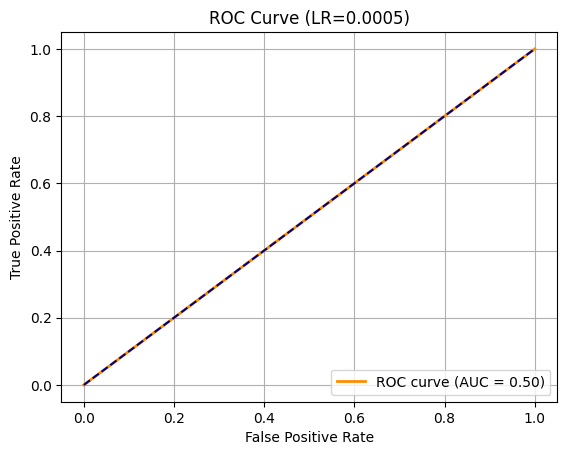

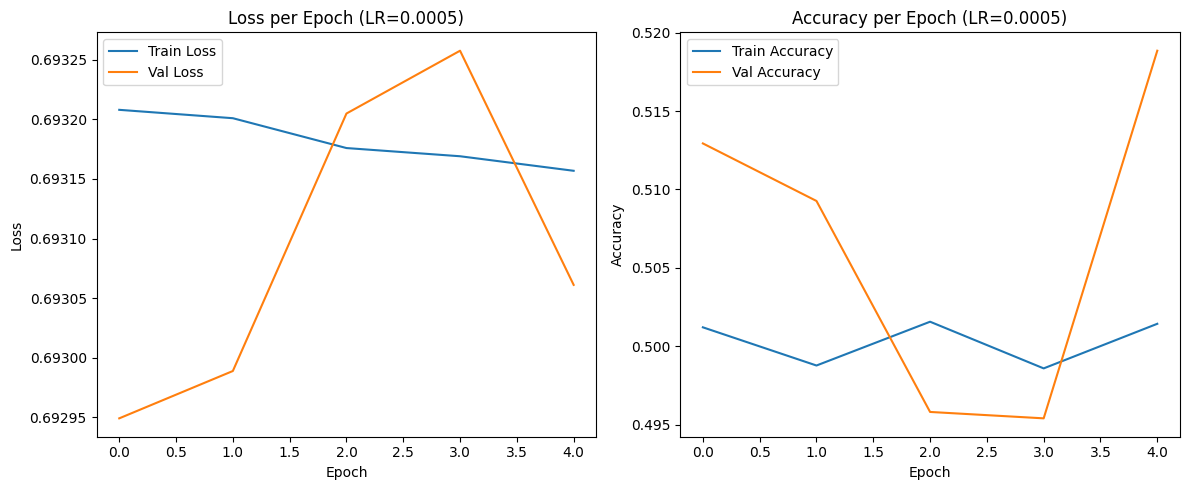

✅ Saved model to matchnet_lr_5e-04.pth

🔁 Training with learning rate: 0.001
Epoch 1: Train Loss 0.6934, Acc 0.5008 | Val Loss 0.6932, Acc 0.4917
Epoch 2: Train Loss 0.6932, Acc 0.5000 | Val Loss 0.6932, Acc 0.4987
Epoch 3: Train Loss 0.6931, Acc 0.5029 | Val Loss 0.6930, Acc 0.5107
Epoch 4: Train Loss 0.6932, Acc 0.5010 | Val Loss 0.6931, Acc 0.5180
Epoch 5: Train Loss 0.6932, Acc 0.5026 | Val Loss 0.6932, Acc 0.4917


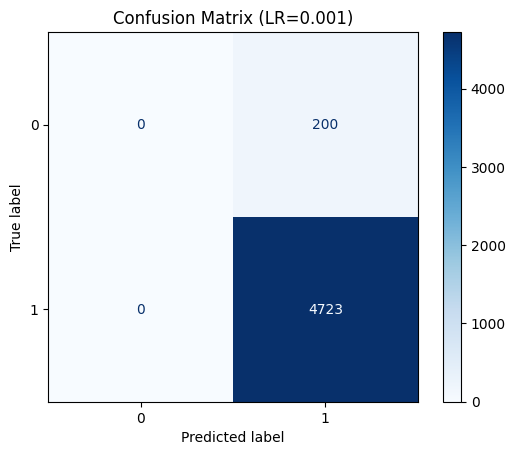

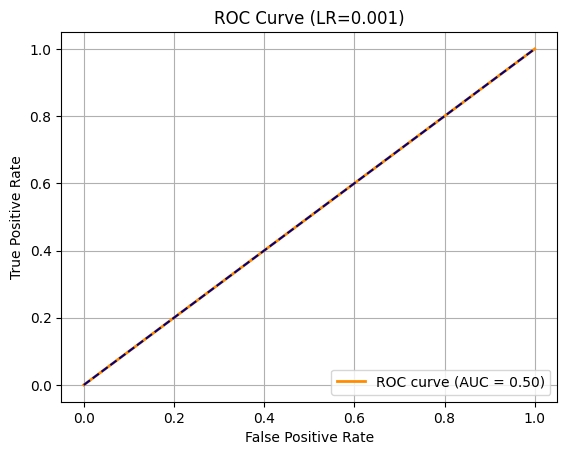

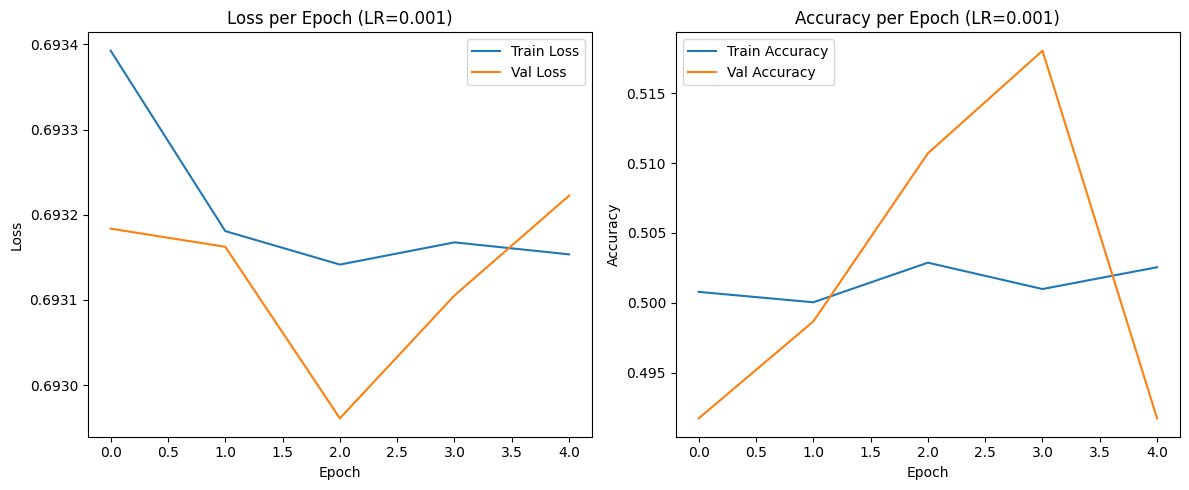

✅ Saved model to matchnet_lr_1e-03.pth


In [ ]:
# === Hyperparameters for tuning ===
learning_rates = [1e-4, 5e-4, 1e-3]
#dropout_rate = 0.3          # try also: 0.5
#bottleneck_dim = 256        # try also: 128 or 512

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for lr in learning_rates:
    print(f"\n🔁 Training with learning rate: {lr}")

    model = MatchNet().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()

    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(5):
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}: Train Loss {train_loss:.4f}, Acc {train_acc:.4f} | Val Loss {val_loss:.4f}, Acc {val_acc:.4f}")

    # === Final Evaluation ===
    from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
    import matplotlib.pyplot as plt
    import numpy as np

    model.eval()
    all_preds, all_probs, all_labels = [], [], []

    with torch.no_grad():
        for img1, img2, labels in test_loader:
            img1, img2 = img1.to(device), img2.to(device)
            outputs = model(img1, img2).squeeze().cpu()
            probs = outputs.numpy().flatten()
            preds = (outputs > 0.5).float().numpy().flatten()
            labels = labels.squeeze().numpy().flatten()

            all_preds.extend(preds)
            all_probs.extend(probs)
            all_labels.extend(labels)

    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix (LR={lr})")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve (LR={lr})')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    # Loss & Accuracy Over Epochs
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss per Epoch (LR={lr})')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy per Epoch (LR={lr})')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Save model checkpoint
    model_path = f"matchnet_lr_{lr:.0e}.pth"
    torch.save(model.state_dict(), model_path)
    print(f"✅ Saved model to {model_path}")

In [ ]:
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# === List of learning rates to test ===
learning_rates_to_test = [1e-4, 5e-4, 1e-3]

# === Evaluation Loop ===
for lr_to_test in learning_rates_to_test:
    print(f"\n🔍 Evaluating model with learning rate: {lr_to_test}")

    # Load the saved model
    model_path = f"matchnet_lr_{lr_to_test:.0e}.pth"
    model = MatchNet().to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    all_preds, all_labels = [], []

    with torch.no_grad():
        for img1, img2, labels in tqdm(test_loader, desc=f"Testing (LR={lr_to_test})"):
            img1, img2 = img1.to(device), img2.to(device)
            outputs = model(img1, img2)
            preds = (outputs.cpu() > 0.5).float()
            all_preds.extend(preds.numpy())
            all_labels.extend(labels.numpy())

    test_acc = accuracy_score(all_labels, all_preds)
    print(f"✅ Test Accuracy (LR={lr_to_test}): {test_acc:.4f}")


🔍 Evaluating model with learning rate: 0.0001





Testing (LR=0.0001):   0%|          | 0/154 [00:00<?, ?it/s]


Testing (LR=0.0001):   1%|▏         | 2/154 [00:00<00:11, 13.69it/s]


Testing (LR=0.0001):   3%|▎         | 4/154 [00:00<00:10, 14.51it/s]


Testing (LR=0.0001):   4%|▍         | 6/154 [00:00<00:09, 14.97it/s]


Testing (LR=0.0001):   5%|▌         | 8/154 [00:00<00:09, 14.64it/s]


Testing (LR=0.0001):   6%|▋         | 10/154 [00:00<00:09, 14.90it/s]


Testing (LR=0.0001):   8%|▊         | 12/154 [00:00<00:09, 15.14it/s]


Testing (LR=0.0001):   9%|▉         | 14/154 [00:00<00:09, 14.97it/s]


Testing (LR=0.0001):  10%|█         | 16/154 [00:01<00:09, 14.81it/s]


Testing (LR=0.0001):  12%|█▏        | 18/154 [00:01<00:09, 14.93it/s]


Testing (LR=0.0001):  14%|█▎        | 21/154 [00:01<00:07, 17.29it/s]


Testing (LR=0.0001):  16%|█▌        | 24/154 [00:01<00:06, 18.74it/s]


Testing (LR=0.0001):  18%|█▊        | 27/154 [00:01<00:06, 19.67it/s]


Testing (LR=0.0001):  19%|█▉        | 29/154 [00:01<00:06, 19.66it/s]


Te

✅ Test Accuracy (LR=0.0001): 0.6813

🔍 Evaluating model with learning rate: 0.0005





Testing (LR=0.0005):   0%|          | 0/154 [00:00<?, ?it/s]


Testing (LR=0.0005):   2%|▏         | 3/154 [00:00<00:07, 21.38it/s]


Testing (LR=0.0005):   4%|▍         | 6/154 [00:00<00:07, 19.58it/s]


Testing (LR=0.0005):   6%|▌         | 9/154 [00:00<00:07, 20.62it/s]


Testing (LR=0.0005):   8%|▊         | 12/154 [00:00<00:06, 21.11it/s]


Testing (LR=0.0005):  10%|▉         | 15/154 [00:00<00:06, 21.12it/s]


Testing (LR=0.0005):  12%|█▏        | 18/154 [00:00<00:06, 20.78it/s]


Testing (LR=0.0005):  14%|█▎        | 21/154 [00:01<00:06, 20.80it/s]


Testing (LR=0.0005):  16%|█▌        | 24/154 [00:01<00:06, 21.31it/s]


Testing (LR=0.0005):  18%|█▊        | 27/154 [00:01<00:05, 21.67it/s]


Testing (LR=0.0005):  19%|█▉        | 30/154 [00:01<00:05, 21.83it/s]


Testing (LR=0.0005):  21%|██▏       | 33/154 [00:01<00:05, 21.67it/s]


Testing (LR=0.0005):  23%|██▎       | 36/154 [00:01<00:05, 21.81it/s]


Testing (LR=0.0005):  25%|██▌       | 39/154 [00:01<00:05, 21.21it/s]


T

✅ Test Accuracy (LR=0.0005): 0.9594

🔍 Evaluating model with learning rate: 0.001





Testing (LR=0.001):   0%|          | 0/154 [00:00<?, ?it/s]


Testing (LR=0.001):   2%|▏         | 3/154 [00:00<00:06, 22.22it/s]


Testing (LR=0.001):   4%|▍         | 6/154 [00:00<00:06, 21.37it/s]


Testing (LR=0.001):   6%|▌         | 9/154 [00:00<00:06, 21.84it/s]


Testing (LR=0.001):   8%|▊         | 12/154 [00:00<00:06, 21.46it/s]


Testing (LR=0.001):  10%|▉         | 15/154 [00:00<00:06, 21.83it/s]


Testing (LR=0.001):  12%|█▏        | 18/154 [00:00<00:06, 21.78it/s]


Testing (LR=0.001):  14%|█▎        | 21/154 [00:00<00:06, 21.98it/s]


Testing (LR=0.001):  16%|█▌        | 24/154 [00:01<00:05, 21.74it/s]


Testing (LR=0.001):  18%|█▊        | 27/154 [00:01<00:05, 21.63it/s]


Testing (LR=0.001):  19%|█▉        | 30/154 [00:01<00:05, 21.90it/s]


Testing (LR=0.001):  21%|██▏       | 33/154 [00:01<00:05, 21.98it/s]


Testing (LR=0.001):  23%|██▎       | 36/154 [00:01<00:05, 21.59it/s]


Testing (LR=0.001):  25%|██▌       | 39/154 [00:01<00:05, 21.78it/s]


Testing (LR=0.0

✅ Test Accuracy (LR=0.001): 0.9594


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
import random
import matplotlib.pyplot as plt

def evaluate_on_50000_pairs(model, dataset, transform, device, threshold=0.5):
    num_pairs = 50000
    all_preds = []
    all_labels = []
    sampled_pairs = set()
    num_samples = len(dataset)

    model.eval()

    with torch.no_grad():
        pbar = tqdm(total=num_pairs, desc="Evaluating 50k Unique Pairs")

        while len(sampled_pairs) < num_pairs:
            idx1, idx2 = random.sample(range(num_samples), 2)
            pair = tuple(sorted((idx1, idx2)))

            if pair in sampled_pairs:
                continue  # Skip duplicates

            sampled_pairs.add(pair)
            pbar.update(1)

            # Load and transform images
            img1 = dataset[idx1]['image']
            img2 = dataset[idx2]['image']
            label1 = dataset[idx1]['label']
            label2 = dataset[idx2]['label']
            actual = 1 if label1 == label2 else 0

            img1_tensor = transform(img1).unsqueeze(0).to(device)
            img2_tensor = transform(img2).unsqueeze(0).to(device)

            # Predict
            score = model(img1_tensor, img2_tensor).item()
            pred = 1 if score > threshold else 0

            all_preds.append(pred)
            all_labels.append(actual)

        pbar.close()

    # Calculate Accuracy
    acc = accuracy_score(all_labels, all_preds)
    print(f"\n✅ Final Accuracy on 50,000 unique pairs: {acc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Different", "Same"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix on 50,000 Pairs")
    plt.grid(False)
    plt.show()

    return acc, all_preds, all_labels


Streaming output truncated to the last 5000 lines.

Evaluating 50k Unique Pairs:   1%|          | 414/50000 [00:02<02:48, 294.90it/s]


Evaluating 50k Unique Pairs:   1%|          | 447/50000 [00:02<02:43, 303.48it/s]


Evaluating 50k Unique Pairs:   1%|          | 479/50000 [00:02<02:42, 305.41it/s]


Evaluating 50k Unique Pairs:   1%|          | 510/50000 [00:02<02:44, 300.80it/s]


Evaluating 50k Unique Pairs:   1%|          | 541/50000 [00:02<02:54, 283.57it/s]


Evaluating 50k Unique Pairs:   1%|          | 571/50000 [00:02<02:52, 287.11it/s]


Evaluating 50k Unique Pairs:   1%|          | 601/50000 [00:02<02:49, 290.71it/s]


Evaluating 50k Unique Pairs:   1%|▏         | 633/50000 [00:02<02:45, 297.87it/s]


Evaluating 50k Unique Pairs:   1%|▏         | 663/50000 [00:02<02:49, 291.39it/s]


Evaluating 50k Unique Pairs:   1%|▏         | 693/50000 [00:02<02:48, 292.73it/s]


Evaluating 50k Unique Pairs:   1%|▏         | 725/50000 [00:03<02:44, 300.39it/s]


Evaluating 50k Unique Pa


✅ Final Accuracy on 50,000 unique pairs: 0.5189


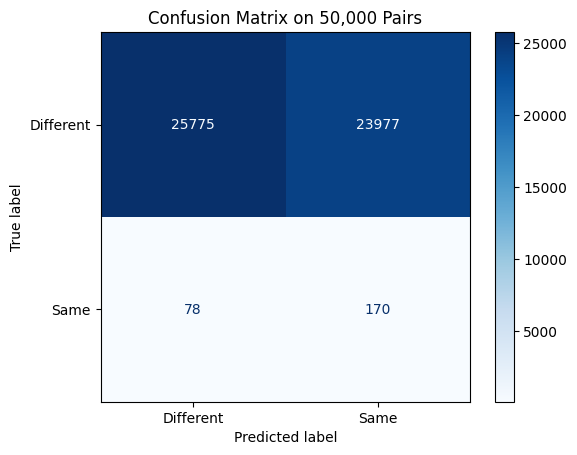

In [ ]:
# === Load the saved model trained with LR = 1e-4 ===
lr_to_test = 1e-4
model_path = f"matchnet_lr_{lr_to_test:.0e}.pth"

# Reinitialize and load the model
model = MatchNet().to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

# === Evaluate on 50,000 unique random pairs ===
acc, preds, labels = evaluate_on_50000_pairs(model, test_dataset, transform, device)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
import random
import matplotlib.pyplot as plt

def evaluate_on_50000_balanced_pairs(model, dataset, transform, device, threshold=0.5):
    num_positive = 25000
    num_negative = 25000
    all_preds = []
    all_labels = []
    positive_pairs = set()
    negative_pairs = set()
    num_samples = len(dataset)

    # Build label-to-index mapping
    label_to_indices = {}
    for i, item in enumerate(dataset):
        label = item['label']
        label_to_indices.setdefault(label, []).append(i)

    model.eval()

    with torch.no_grad():
        pbar = tqdm(total=num_positive + num_negative, desc="Evaluating 50k Balanced Pairs")

        # Generate positive pairs
        while len(positive_pairs) < num_positive:
            label = random.choice(list(label_to_indices.keys()))
            indices = label_to_indices[label]
            if len(indices) < 2:
                continue
            idx1, idx2 = random.sample(indices, 2)
            pair = tuple(sorted((idx1, idx2)))
            if pair in positive_pairs:
                continue
            positive_pairs.add(pair)

            img1 = transform(dataset[idx1]['image']).unsqueeze(0).to(device)
            img2 = transform(dataset[idx2]['image']).unsqueeze(0).to(device)
            score = model(img1, img2).item()
            pred = 1 if score > threshold else 0

            all_preds.append(pred)
            all_labels.append(1)
            pbar.update(1)

        # Generate negative pairs
        labels_list = list(label_to_indices.keys())
        while len(negative_pairs) < num_negative:
            label1, label2 = random.sample(labels_list, 2)
            idx1 = random.choice(label_to_indices[label1])
            idx2 = random.choice(label_to_indices[label2])
            pair = tuple(sorted((idx1, idx2)))
            if pair in positive_pairs or pair in negative_pairs:
                continue
            negative_pairs.add(pair)

            img1 = transform(dataset[idx1]['image']).unsqueeze(0).to(device)
            img2 = transform(dataset[idx2]['image']).unsqueeze(0).to(device)
            score = model(img1, img2).item()
            pred = 1 if score > threshold else 0

            all_preds.append(pred)
            all_labels.append(0)
            pbar.update(1)

        pbar.close()

    # Accuracy
    acc = accuracy_score(all_labels, all_preds)
    print(f"\n✅ Final Accuracy on 50/50 Balanced Pairs: {acc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Different", "Same"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix on 50k Balanced Pairs")
    plt.grid(False)
    plt.show()

    return acc, all_preds, all_labels





Evaluating 50k Balanced Pairs:   0%|          | 0/50000 [00:00<?, ?it/s]


Evaluating 50k Balanced Pairs:   0%|          | 38/50000 [00:00<02:14, 370.53it/s]


Evaluating 50k Balanced Pairs:   0%|          | 76/50000 [00:00<02:24, 345.72it/s]


Evaluating 50k Balanced Pairs:   0%|          | 113/50000 [00:00<02:21, 352.80it/s]


Evaluating 50k Balanced Pairs:   0%|          | 150/50000 [00:00<02:19, 357.25it/s]


Evaluating 50k Balanced Pairs:   0%|          | 188/50000 [00:00<02:17, 362.23it/s]


Evaluating 50k Balanced Pairs:   0%|          | 225/50000 [00:00<02:16, 364.52it/s]


Evaluating 50k Balanced Pairs:   1%|          | 263/50000 [00:00<02:15, 367.05it/s]


Evaluating 50k Balanced Pairs:   1%|          | 300/50000 [00:00<02:15, 367.81it/s]


Evaluating 50k Balanced Pairs:   1%|          | 337/50000 [00:00<02:16, 364.67it/s]


Evaluating 50k Balanced Pairs:   1%|          | 374/50000 [00:01<02:15, 366.02it/s]


Evaluating 50k Balanced Pairs:   1%|          | 411/50000 [00:01


✅ Final Accuracy on 50/50 Balanced Pairs: 0.6087


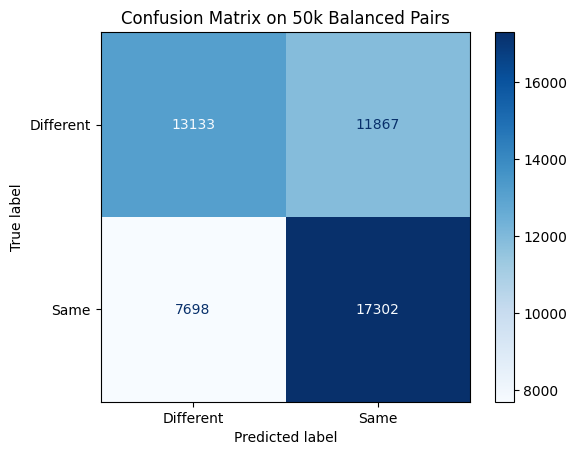

In [ ]:
# === Load the saved model trained with LR = 1e-4 ===
lr_to_test = 1e-4
model_path = f"matchnet_lr_{lr_to_test:.0e}.pth"

# Reinitialize and load the model
model = MatchNet().to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

# === Evaluate on 50,000 balanced pairs ===
acc, preds, labels = evaluate_on_50000_balanced_pairs(model, test_dataset, transform, device)


✅ Final Accuracy on 50/50 Balanced Pairs: 0.5000


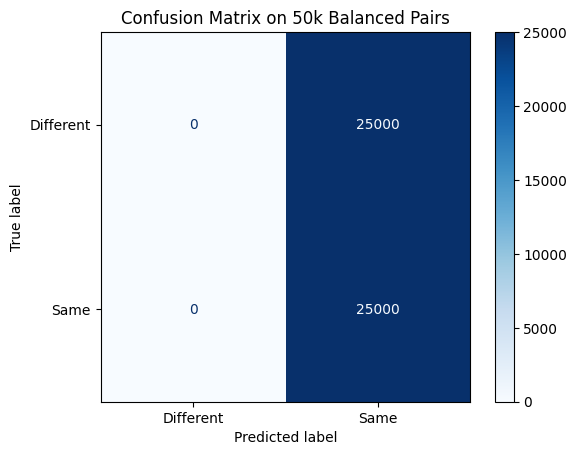

In [ ]:
# === Load the saved model trained with LR = 5e-4 ===
lr_to_test = 5e-4
model_path = f"matchnet_lr_{lr_to_test:.0e}.pth"

# Reinitialize and load the model
model = MatchNet().to(device)
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()

# === Evaluate on 50,000 balanced pairs ===
acc, preds, labels = evaluate_on_50000_balanced_pairs(model, test_dataset, transform, torch.device('cpu'))


✅ Final Accuracy on 50/50 Balanced Pairs: 0.5000


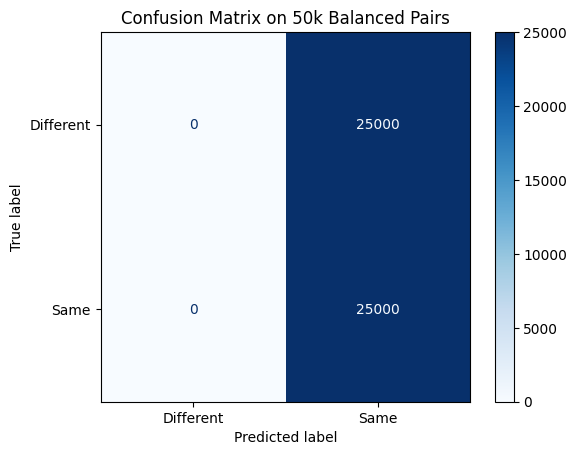

In [ ]:
# === Load the saved model trained with LR = 1e-3 ===
lr_to_test = 1e-3
model_path = f"matchnet_lr_{lr_to_test:.0e}.pth"

# Reinitialize and load the model
model = MatchNet().to(device)
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()

# === Evaluate on 50,000 balanced pairs ===
acc, preds, labels = evaluate_on_50000_balanced_pairs(model, test_dataset, transform, torch.device('cpu'))

In [ ]:
# Set path to your model inside Google Drive
folder_path = '/content/drive/MyDrive/ML_Project_3'

lr_to_test = 1e-4
model_path = f"{folder_path}/matchnet_lr_{lr_to_test:.0e}.pth"

# Load the model
model = MatchNet().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

MatchNet(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 24, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(24, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(96, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (bottleneck): Linear(in_features=4096, out_features=128, bias=True)
  (metric_network): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)


In [ ]:
import torch
import numpy as np
from tqdm import tqdm

def compute_test_embeddings(model, dataset, transform, device):
    """
    Precompute and store embeddings for all test images.
    """
    model.eval()
    all_embeddings = []
    all_labels = []

    with torch.no_grad():
        for idx in tqdm(range(len(dataset)), desc="Computing Test Embeddings"):
            img = dataset[idx]['image']
            label = dataset[idx]['label']

            img_tensor = transform(img).unsqueeze(0).to(device)

            # Extract features using feature extractor (NOT whole model head)
            embedding = model.extract_features(img_tensor)  # Use your MatchNet's extract_features method
            all_embeddings.append(embedding.squeeze(0).cpu().numpy())
            all_labels.append(label)

    embeddings = np.stack(all_embeddings)
    labels = np.array(all_labels)

    return embeddings, labels


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import random
import numpy as np
from tqdm import tqdm

def evaluate_similarity_from_embeddings(embeddings, labels, threshold=0.96, num_pairs=None):
    """
    Evaluate similarity prediction based on precomputed embeddings.
    """
    all_preds = []
    all_truths = []
    num_samples = len(labels)

    # Prepare pairs
    sampled_pairs = []
    if num_pairs is None:
        # Full evaluation (all unique pairs)
        print("Preparing full set of pairs...")
        for i in range(num_samples):
            for j in range(i + 1, num_samples):
                sampled_pairs.append((i, j))
    else:
        # Randomly sample pairs
        while len(sampled_pairs) < num_pairs:
            idx1, idx2 = random.sample(range(num_samples), 2)
            if idx1 != idx2:
                sampled_pairs.append((min(idx1, idx2), max(idx1, idx2)))

    print(f"Evaluating {len(sampled_pairs)} pairs...")

    for idx1, idx2 in tqdm(sampled_pairs, desc="Evaluating Pairs"):
        emb1 = embeddings[idx1].reshape(1, -1)
        emb2 = embeddings[idx2].reshape(1, -1)

        score = cosine_similarity(emb1, emb2)[0][0]
        pred_similar = 1 if score > threshold else 0
        true_similar = 1 if labels[idx1] == labels[idx2] else 0

        all_preds.append(pred_similar)
        all_truths.append(true_similar)

    # Calculate metrics
    acc = accuracy_score(all_truths, all_preds)
    print(f"✅ Final Similarity Prediction Accuracy: {acc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(all_truths, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Different", "Same"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix (Similarity Prediction)")
    plt.grid(False)
    plt.show()

    return acc, cm




Computing Test Embeddings:   0%|          | 0/4923 [00:00<?, ?it/s]

Computing Test Embeddings:   1%|          | 61/4923 [00:00<00:08, 607.74it/s]

Computing Test Embeddings:   2%|▏         | 122/4923 [00:00<00:07, 607.68it/s]

Computing Test Embeddings:   4%|▎         | 184/4923 [00:00<00:07, 609.50it/s]

Computing Test Embeddings:   5%|▍         | 245/4923 [00:00<00:08, 574.54it/s]

Computing Test Embeddings:   6%|▋         | 309/4923 [00:00<00:07, 594.43it/s]

Computing Test Embeddings:   8%|▊         | 373/4923 [00:00<00:07, 607.22it/s]

Computing Test Embeddings:   9%|▉         | 437/4923 [00:00<00:07, 614.53it/s]

Computing Test Embeddings:  10%|█         | 500/4923 [00:00<00:07, 617.31it/s]

Computing Test Embeddings:  11%|█▏        | 562/4923 [00:00<00:07, 617.04it/s]

Computing Test Embeddings:  13%|█▎        | 626/4923 [00:01<00:06, 620.90it/s]

Computing Test Embeddings:  14%|█▍        | 689/4923 [00:01<00:07, 600.80it/s]

Computing Test Embeddings:  15%|█▌        | 750/49

Preparing full set of pairs...
Evaluating 12115503 pairs...


Streaming output truncated to the last 5000 lines.

Evaluating Pairs:  96%|█████████▌| 11584990/12115503 [1:37:16<03:52, 2279.41it/s]

Evaluating Pairs:  96%|█████████▌| 11585232/12115503 [1:37:16<03:48, 2318.65it/s]

Evaluating Pairs:  96%|█████████▌| 11585480/12115503 [1:37:16<03:44, 2365.60it/s]

Evaluating Pairs:  96%|█████████▌| 11585718/12115503 [1:37:17<03:56, 2243.53it/s]

Evaluating Pairs:  96%|█████████▌| 11585959/12115503 [1:37:17<03:51, 2288.31it/s]

Evaluating Pairs:  96%|█████████▌| 11586198/12115503 [1:37:17<03:48, 2316.20it/s]

Evaluating Pairs:  96%|█████████▌| 11586431/12115503 [1:37:17<03:50, 2293.18it/s]

Evaluating Pairs:  96%|█████████▌| 11586662/12115503 [1:37:17<04:11, 2103.99it/s]

Evaluating Pairs:  96%|█████████▌| 11586879/12115503 [1:37:17<04:09, 2120.79it/s]

Evaluating Pairs:  96%|█████████▌| 11587094/12115503 [1:37:17<04:10, 2105.79it/s]

Evaluating Pairs:  96%|█████████▌| 11587307/12115503 [1:37:17<04:13, 2083.46it/s]

Evaluating Pairs:  96%|█████████▌| 

✅ Final Similarity Prediction Accuracy: 0.9428


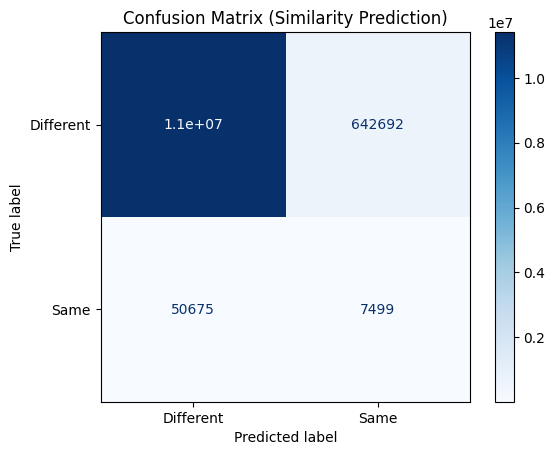

In [ ]:
# 1. Precompute embeddings
embeddings, labels = compute_test_embeddings(model, test_dataset, transform, device)

# 2. Evaluate similarity (on all possible pairs OR sampled pairs)
acc, cm = evaluate_similarity_from_embeddings(embeddings, labels, threshold=0.96)
# Or num_pairs=None for full evaluation


**BEIT MODEL**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from transformers import BeitFeatureExtractor, BeitForImageClassification
import torchvision.transforms as T
from datasets import load_dataset
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

In [ ]:
# Load TinyImageNet 200 clean dataset
train_dataset = load_dataset('slegroux/tiny-imagenet-200-clean', split='train')
val_dataset = load_dataset('slegroux/tiny-imagenet-200-clean', split='validation')
test_dataset = load_dataset('slegroux/tiny-imagenet-200-clean', split='test')

In [ ]:
# Load BEiT feature extractor
feature_extractor = BeitFeatureExtractor.from_pretrained("microsoft/beit-base-patch16-224")

# Define transform compatible with BEiT
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
])

In [ ]:
class TinyImageNetDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, transform):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img = self.dataset[idx]['image']
        label = self.dataset[idx]['label']
        img = self.transform(img)
        return img, label

In [ ]:
batch_size = 32

train_loader = DataLoader(TinyImageNetDataset(train_dataset, transform), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TinyImageNetDataset(val_dataset, transform), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TinyImageNetDataset(test_dataset, transform), batch_size=batch_size, shuffle=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
model = BeitForImageClassification.from_pretrained(
    "microsoft/beit-base-patch16-224",
    num_labels=200,
    ignore_mismatched_sizes=True  # 🔥 add this
)
model = model.to(device)

Error while downloading from https://cdn-lfs.hf.co/microsoft/beit-base-patch16-224/873a67558f17cdd9d9018eaf308288f6dc72d030af20391df9ccbb7e10be89cc?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27model.safetensors%3B+filename%3D%22model.safetensors%22%3B&Expires=1745803104&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0NTgwMzEwNH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9taWNyb3NvZnQvYmVpdC1iYXNlLXBhdGNoMTYtMjI0Lzg3M2E2NzU1OGYxN2NkZDlkOTAxOGVhZjMwODI4OGY2ZGM3MmQwMzBhZjIwMzkxZGY5Y2NiYjdlMTBiZTg5Y2M%7EcmVzcG9uc2UtY29udGVudC1kaXNwb3NpdGlvbj0qIn1dfQ__&Signature=QrfZP-E0fb69Nrj9QRabBSoc-onxQmyrvrUMS0nfUZgCKlCcY3VYpzyLK3WaMzHY3kjnE%7Ec2311f2nC%7E%7EuJ0LQIrAP0AUdWH9mWyynWGlj0wv-22pYZ1BXe1CaWhuA5mjSlhWlPGO8CV4EruNMa01ekuJhhwW2Ws9ZjRg8OVBTYeMljqSu1Oc3LCz3RkBoKffHi2FC3ozg-aInJ%7E99wNmsc%7E-k3djjrSn4jJJzvX-gjfj%7Eb%7EvBX5e7MHf-bszz3eFX-lYMqMoV6E5MmNL8Mh3FXYMdQKwdaE4SxnB67wCjl4XbcBajaSOCe4iDhJGaHPQ7RPBYztF5ZeFzcIw7Byeg__&Key-Pair-Id=K

In [ ]:
import os

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-4)

num_epochs = 5
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train, total_train = 0, 0

    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
        imgs, labels = imgs.to(device), labels.to(device)

        outputs = model(imgs).logits
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        preds = outputs.argmax(dim=1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val, total_val = 0, 0

    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs).logits
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = outputs.argmax(dim=1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_loss = val_loss / len(val_loader)
    val_acc = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Train Acc = {train_acc:.4f}, Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}")

    os.makedirs('models', exist_ok=True)

    if epoch % 2 == 0:
        save_path = f"models/beit_model_epoch_{epoch+1}.pth"
        torch.save(model.state_dict(), save_path)
        print(f"Model saved to {save_path}")


Epoch 1 [Val]: 100%|██████████| 154/154 [01:32<00:00,  1.66it/s]


Epoch 1: Train Loss = 4.5340, Train Acc = 0.0794, Val Loss = 3.9627, Val Acc = 0.1495
Model saved to models/beit_model_epoch_1.pth


Epoch 2 [Val]: 100%|██████████| 154/154 [05:35<00:00,  2.18s/it]


Epoch 2: Train Loss = 3.6231, Train Acc = 0.1966, Val Loss = 3.4701, Val Acc = 0.2198


Epoch 3 [Val]: 100%|██████████| 154/154 [02:52<00:00,  1.12s/it]


Epoch 3: Train Loss = 3.1831, Train Acc = 0.2710, Val Loss = 3.0167, Val Acc = 0.3060
Model saved to models/beit_model_epoch_3.pth


Epoch 4 [Val]: 100%|██████████| 154/154 [02:15<00:00,  1.14it/s]


Epoch 4: Train Loss = 2.8463, Train Acc = 0.3301, Val Loss = 2.8761, Val Acc = 0.3255


Epoch 5 [Val]: 100%|██████████| 154/154 [01:14<00:00,  2.05it/s]


Epoch 5: Train Loss = 2.5549, Train Acc = 0.3839, Val Loss = 2.6836, Val Acc = 0.3585
Model saved to models/beit_model_epoch_5.pth


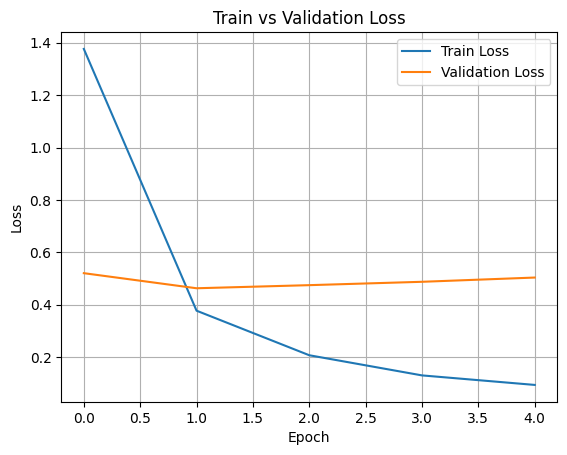

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
batch_size = 128

transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
])

train_loader = DataLoader(TinyImageNetDataset(train_dataset, transform), batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(TinyImageNetDataset(val_dataset, transform), batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

In [ ]:
# Load BEiT model
model = BeitForImageClassification.from_pretrained(
    "microsoft/beit-base-patch16-224",
    num_labels=200,
    ignore_mismatched_sizes=True
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

# Freeze everything except classifier
for name, param in model.named_parameters():
    if 'classifier' not in name:
        param.requires_grad = False

Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([200]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([200, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


cuda


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-5, weight_decay=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

C:\Users\spitz\AppData\Local\Temp\ipykernel_27036\1709523866.py:1: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # For Mixed Precision
Epoch 1 [Train]:   0%|          | 0/768 [00:00<?, ?it/s]C:\Users\spitz\AppData\Local\Temp\ipykernel_27036\1709523866.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed Precision
Epoch 1 [Val]:   0%|          | 0/39 [00:00<?, ?it/s]C:\Users\spitz\AppData\Local\Temp\ipykernel_27036\1709523866.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1 [Val]: 100%|██████████| 39/39 [00:26<00:00,  1.46it/s]


Epoch 1: Train Loss = 2.7740, Train Acc = 0.5959, Val Loss = 1.0456, Val Acc = 0.8503
Saved Best Model (Val Acc: 0.8503)


Epoch 2 [Val]: 100%|██████████| 39/39 [00:29<00:00,  1.30it/s]


Epoch 2: Train Loss = 0.8366, Train Acc = 0.8503, Val Loss = 0.6006, Val Acc = 0.8729
Saved Best Model (Val Acc: 0.8729)


Epoch 3 [Val]: 100%|██████████| 39/39 [00:29<00:00,  1.31it/s]


Epoch 3: Train Loss = 0.5993, Train Acc = 0.8670, Val Loss = 0.5056, Val Acc = 0.8796
Saved Best Model (Val Acc: 0.8796)


Epoch 4 [Val]: 100%|██████████| 39/39 [00:29<00:00,  1.32it/s]


Epoch 4: Train Loss = 0.5380, Train Acc = 0.8738, Val Loss = 0.4992, Val Acc = 0.8796


Epoch 5 [Val]: 100%|██████████| 39/39 [00:31<00:00,  1.25it/s]


Epoch 5: Train Loss = 0.5280, Train Acc = 0.8766, Val Loss = 0.4932, Val Acc = 0.8806
Saved Best Model (Val Acc: 0.8806)

Training complete.


Evaluating for Confusion Matrix:   0%|          | 0/39 [00:00<?, ?it/s]C:\Users\spitz\AppData\Local\Temp\ipykernel_27036\1709523866.py:86: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluating for Confusion Matrix: 100%|██████████| 39/39 [00:31<00:00,  1.22it/s]


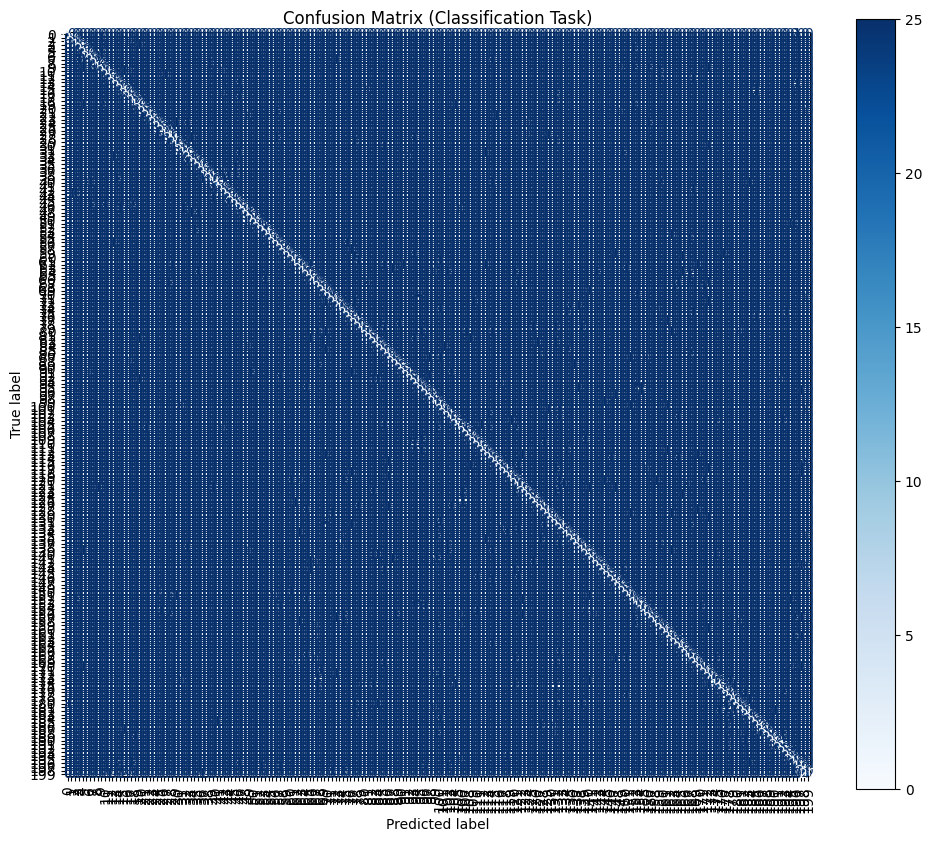

array([[24,  0,  0, ...,  0,  0,  0],
       [ 0, 24,  0, ...,  0,  0,  0],
       [ 0,  0, 22, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 19,  0,  0],
       [ 0,  0,  0, ...,  2, 20,  0],
       [ 0,  0,  0, ...,  0,  0, 20]], dtype=int64)

In [ ]:
scaler = torch.cuda.amp.GradScaler()  # For Mixed Precision

num_epochs = 5
train_losses, val_losses = [], []
best_val_acc = 0.0
save_path = "beit_best_model.pth"

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():  # Mixed Precision
            outputs = model(imgs).logits
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
            imgs, labels = imgs.to(device), labels.to(device)

            with torch.cuda.amp.autocast():
                outputs = model(imgs).logits
                loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss = val_loss / len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)

    scheduler.step()

    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Train Acc = {train_acc:.4f}, Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), save_path)
        print(f"Saved Best Model (Val Acc: {best_val_acc:.4f})")

print("\nTraining complete.")
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

def plot_confusion_matrix_classification(model, dataloader, device, classes=None):
    """
    Plot confusion matrix for classification task.
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for imgs, labels in tqdm(dataloader, desc="Evaluating for Confusion Matrix"):
            imgs, labels = imgs.to(device), labels.to(device)

            with torch.cuda.amp.autocast():
                outputs = model(imgs).logits
            preds = outputs.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(12, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
    plt.title("Confusion Matrix (Classification Task)")
    plt.grid(False)
    plt.show()

    return cm
# Assuming you have a test_loader or val_loader
plot_confusion_matrix_classification(model, val_loader, device)

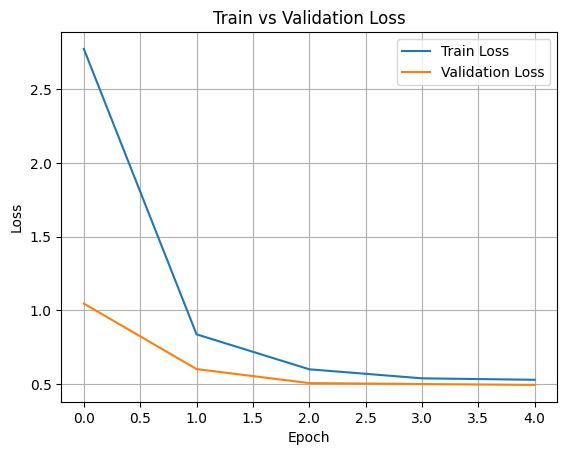

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Load BEiT feature extractor
feature_extractor = BeitFeatureExtractor.from_pretrained("microsoft/beit-base-patch16-224")

# Define transform compatible with BEiT
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
])

C:\Users\arvin\AppData\Local\Programs\Python\Python313\Lib\site-packages\transformers\models\beit\feature_extraction_beit.py:28: FutureWarning: The class BeitFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use BeitImageProcessor instead.
  warnings.warn(
C:\Users\arvin\AppData\Local\Programs\Python\Python313\Lib\site-packages\transformers\utils\deprecation.py:172: UserWarning: The following named arguments are not valid for `BeitFeatureExtractor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


In [ ]:
class TinyImageNetDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, transform):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img = self.dataset[idx]['image']
        label = self.dataset[idx]['label']
        img = self.transform(img)
        return img, label

In [ ]:
batch_size = 64

train_loader = DataLoader(TinyImageNetDataset(train_dataset, transform), batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(TinyImageNetDataset(val_dataset, transform), batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load BEiT model
model = BeitForImageClassification.from_pretrained(
    "microsoft/beit-base-patch16-224",
    num_labels=200,
    ignore_mismatched_sizes=True
)
model = model.to(device)

# Freeze everything except classifier
for name, param in model.named_parameters():
    if 'classifier' not in name:
        param.requires_grad = False

Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([200]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([200, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-4, weight_decay=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

C:\Users\arvin\AppData\Local\Temp\ipykernel_19028\3052945054.py:1: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # For Mixed Precision
C:\Users\arvin\AppData\Local\Temp\ipykernel_19028\3052945054.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed Precision
Epoch 1 [Train]: 100%|█████████████████████████████████████████████████████████████| 1535/1535 [20:16<00:00,  1.26it/s]
C:\Users\arvin\AppData\Local\Temp\ipykernel_19028\3052945054.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1 [Val]: 100%|███████████████████████████████████████████████████████████████████| 77/77 [00:59<00:00,  1.30it/s]


Epoch 1: Train Loss = 0.6920, Train Acc = 0.8455, Val Loss = 0.4231, Val Acc = 0.8878
Saved Best Model (Val Acc: 0.8878)


Epoch 2 [Val]: 100%|███████████████████████████████████████████████████████████████████| 77/77 [00:56<00:00,  1.35it/s]


Epoch 2: Train Loss = 0.3734, Train Acc = 0.8973, Val Loss = 0.4192, Val Acc = 0.8878


Epoch 3 [Val]: 100%|███████████████████████████████████████████████████████████████████| 77/77 [00:56<00:00,  1.36it/s]


Epoch 3: Train Loss = 0.3085, Train Acc = 0.9120, Val Loss = 0.4201, Val Acc = 0.8886
Saved Best Model (Val Acc: 0.8886)


Epoch 4 [Val]: 100%|███████████████████████████████████████████████████████████████████| 77/77 [00:57<00:00,  1.34it/s]


Epoch 4: Train Loss = 0.2180, Train Acc = 0.9377, Val Loss = 0.4035, Val Acc = 0.8918
Saved Best Model (Val Acc: 0.8918)


Epoch 5 [Val]: 100%|███████████████████████████████████████████████████████████████████| 77/77 [00:57<00:00,  1.34it/s]


Epoch 5: Train Loss = 0.2109, Train Acc = 0.9405, Val Loss = 0.4006, Val Acc = 0.8916

Training complete.


C:\Users\arvin\AppData\Local\Temp\ipykernel_19028\3052945054.py:86: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluating for Confusion Matrix: 100%|█████████████████████████████████████████████████| 77/77 [00:56<00:00,  1.37it/s]


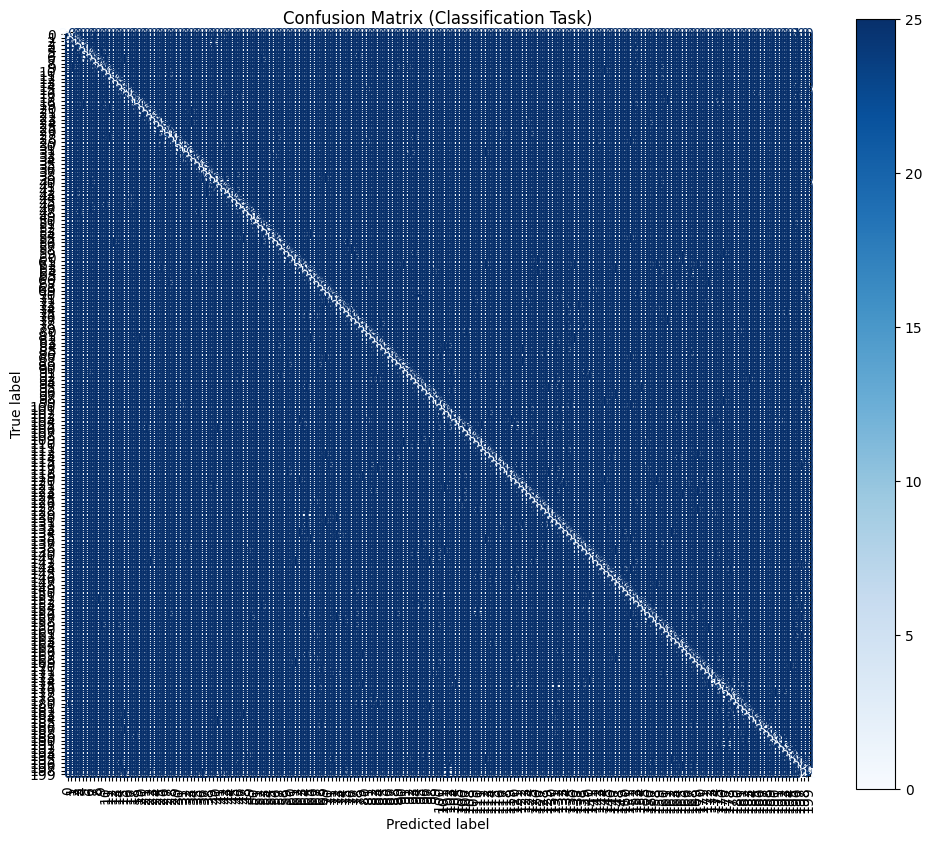

array([[24,  0,  0, ...,  0,  0,  0],
       [ 0, 23,  0, ...,  0,  0,  0],
       [ 0,  0, 22, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 20,  0,  0],
       [ 0,  0,  0, ...,  2, 19,  0],
       [ 0,  0,  0, ...,  0,  0, 21]])

In [ ]:
scaler = torch.cuda.amp.GradScaler()  # For Mixed Precision

num_epochs = 5
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
best_val_acc = 0.0
save_path = "beit_best_model.pth"

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():  # Mixed Precision
            outputs = model(imgs).logits
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
            imgs, labels = imgs.to(device), labels.to(device)

            with torch.cuda.amp.autocast():
                outputs = model(imgs).logits
                loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss = val_loss / len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    scheduler.step()

    # Print everything
    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Train Acc = {train_acc:.4f}, "
          f"Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), save_path)
        print(f"Saved Best Model (Val Acc: {best_val_acc:.4f})")

print("\nTraining complete.")

def plot_confusion_matrix_classification(model, dataloader, device, classes=None):
    """
    Plot confusion matrix for classification task.
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for imgs, labels in tqdm(dataloader, desc="Evaluating for Confusion Matrix"):
            imgs, labels = imgs.to(device), labels.to(device)

            with torch.cuda.amp.autocast():
                outputs = model(imgs).logits
            preds = outputs.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(12, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
    plt.title("Confusion Matrix (Classification Task)")
    plt.grid(False)
    plt.show()

    return cm
# Assuming you have a test_loader or val_loader
plot_confusion_matrix_classification(model, val_loader, device)

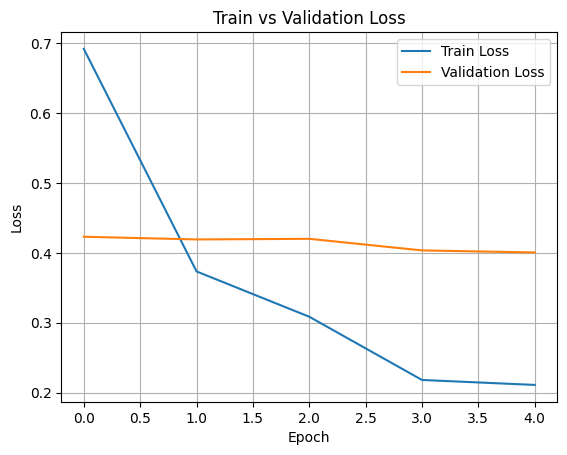

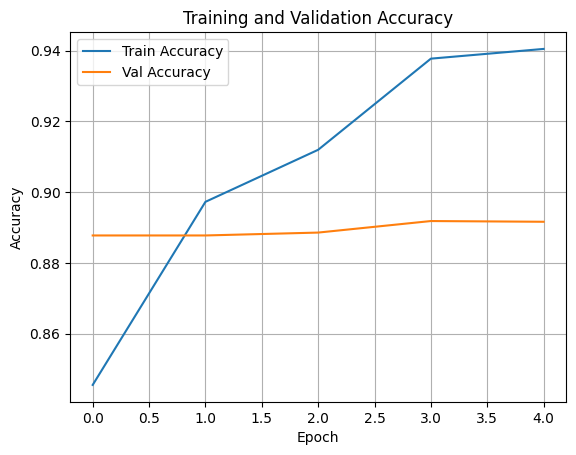

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import torch
import numpy as np
from tqdm import tqdm

def compute_test_embeddings(model, dataset, transform, device):
    """
    Precompute embeddings for all test images.
    """
    model.eval()
    all_embeddings = []
    all_labels = []

    with torch.no_grad():
        for idx in tqdm(range(len(dataset)), desc="Computing Test Embeddings"):
            img = dataset[idx]['image']
            label = dataset[idx]['label']

            img_tensor = transform(img).unsqueeze(0).to(device)

            with torch.cuda.amp.autocast():
                output = model.base_model(img_tensor).last_hidden_state[:, 0]  # CLS token
            all_embeddings.append(output.squeeze(0).cpu().numpy())
            all_labels.append(label)

    embeddings = np.stack(all_embeddings)
    labels = np.array(all_labels)

    return embeddings, labels
embeddings, labels = compute_test_embeddings(model, test_dataset, transform, device)

C:\Users\arvin\AppData\Local\Temp\ipykernel_19028\1690771635.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Computing Test Embeddings: 100%|███████████████████████████████████████████████████| 4923/4923 [07:36<00:00, 10.79it/s]


Preparing full pairs...
Evaluating 12115503 pairs...


Evaluating Pairs: 100%|████████████████████████████████████████████████| 12115503/12115503 [3:09:23<00:00, 1066.14it/s]


Final Similarity Prediction Accuracy: 0.8914


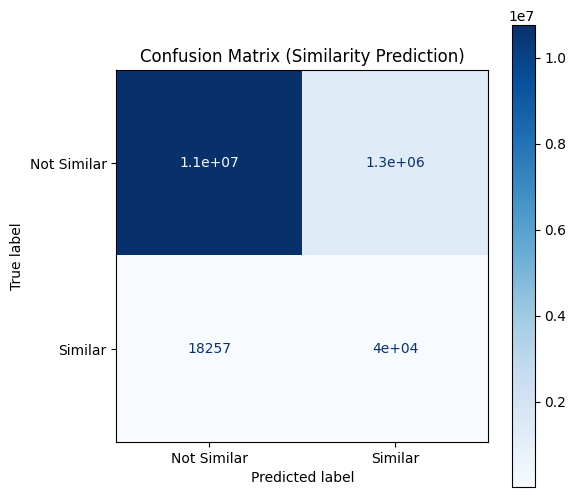

(0.8914102864734547,
 array([[10759967,  1297362],
        [   18257,    39917]]))

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import numpy as np

def evaluate_similarity(embeddings, labels, threshold=0.9992, num_pairs=None):
    """
    Evaluate the similarity prediction accuracy using precomputed embeddings
    and generate confusion matrix.
    """
    all_preds = []
    all_truths = []
    num_samples = len(labels)

    # Prepare sampled pairs
    sampled_pairs = []
    if num_pairs is None:
        # Full evaluation (all possible unique pairs)
        print("Preparing full pairs...")
        for i in range(num_samples):
            for j in range(i + 1, num_samples):
                sampled_pairs.append((i, j))
    else:
        # Random sampled pairs
        while len(sampled_pairs) < num_pairs:
            idx1, idx2 = random.sample(range(num_samples), 2)
            if idx1 != idx2:
                sampled_pairs.append((min(idx1, idx2), max(idx1, idx2)))

    print(f"Evaluating {len(sampled_pairs)} pairs...")

    # Evaluate
    for idx1, idx2 in tqdm(sampled_pairs, desc="Evaluating Pairs"):
        emb1 = embeddings[idx1].reshape(1, -1)
        emb2 = embeddings[idx2].reshape(1, -1)

        score = cosine_similarity(emb1, emb2)[0][0]

        pred_similar = 1 if score > threshold else 0
        true_similar = 1 if labels[idx1] == labels[idx2] else 0

        all_preds.append(pred_similar)
        all_truths.append(true_similar)

    # Compute accuracy
    acc = accuracy_score(all_truths, all_preds)
    print(f"Final Similarity Prediction Accuracy: {acc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(all_truths, all_preds)

    fig, ax = plt.subplots(figsize=(6,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Similar", "Similar"])
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    plt.title("Confusion Matrix (Similarity Prediction)")
    plt.grid(False)
    plt.show()

    return acc, cm
evaluate_similarity(embeddings, labels, threshold=0.9992, num_pairs=None)